In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [ ]:
df = pd.read_parquet('../data/Electric_Vehicle_Population_Data_cleaned.parquet')
df.head()

In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
features = ['Electric Range', 'Vehicle_Age', 'Base MSRP']
df_features = df[features].copy()
df_features['EV_Type'] = df['Electric Vehicle Type'].map({'Battery Electric Vehicle (BEV)': 1, 'Plug-in Hybrid Electric Vehicle (PHEV)': 0})
df_features['Make_encoded'] = pd.factorize(df['Make'])[0]
df_features.head()

In [ ]:
features_for_clustering = ['Electric Range', 'Vehicle_Age', 'Base MSRP', 'EV_Type', 'Make_encoded']
X = df_features[features_for_clustering]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)

In [ ]:
inertia = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'o-')
plt.xlabel('Anzahl der Cluster')
plt.ylabel('Inertia')
plt.title('Ellenbogenverfahren')
plt.grid(True)
plt.show()

In [ ]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=60)
cluster_labels = kmeans.fit_predict(scaled_features)
df_features['Cluster'] = cluster_labels

In [ ]:
centers = scaler.inverse_transform(kmeans.cluster_centers_)
centers_df = pd.DataFrame(centers, columns=features_for_clustering)
centers_df.index.name = 'Cluster'
centers_df

In [ ]:
cluster_sizes = df_features['Cluster'].value_counts().sort_index()
total_vehicles = len(df_features)
percentage = (cluster_sizes / total_vehicles * 100).round(2)

# Zusammenfassung erstellen
summary_df = pd.DataFrame({
    'Count': cluster_sizes,
    'Percentage': percentage,
    'Avg_Range': df_features.groupby('Cluster')['Electric Range'].mean().round(1),
    'Avg_Age': df_features.groupby('Cluster')['Vehicle_Age'].mean().round(1),
    'Avg_MSRP': df_features.groupby('Cluster')['Base MSRP'].mean().round(2),
    'BEV_Ratio': df_features.groupby('Cluster')['EV_Type'].mean().round(3)
})
summary_df

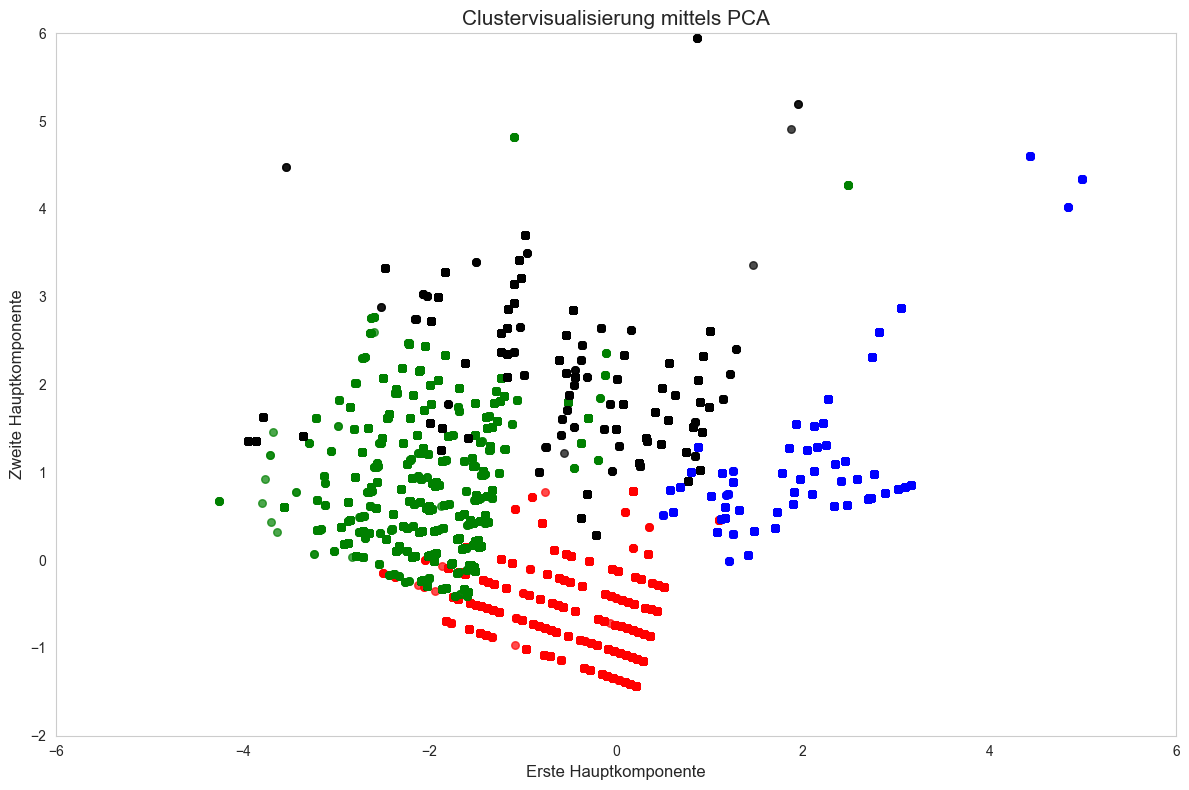

In [105]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)
plt.figure(figsize=(12, 8))
colors = ['red', 'green', 'black', 'blue']
for i in range(n_clusters):
    plt.scatter(pca_result[cluster_labels == i, 0], pca_result[cluster_labels == i, 1], c=colors[i], s=30, alpha=0.7)
plt.title('Clustervisualisierung mittels PCA', fontsize=15)
plt.xlabel('Erste Hauptkomponente', fontsize=12)
plt.ylabel('Zweite Hauptkomponente', fontsize=12)
plt.xlim(-6, 6)
plt.ylim(-2, 6)
plt.grid(False)
plt.tight_layout()
plt.show()

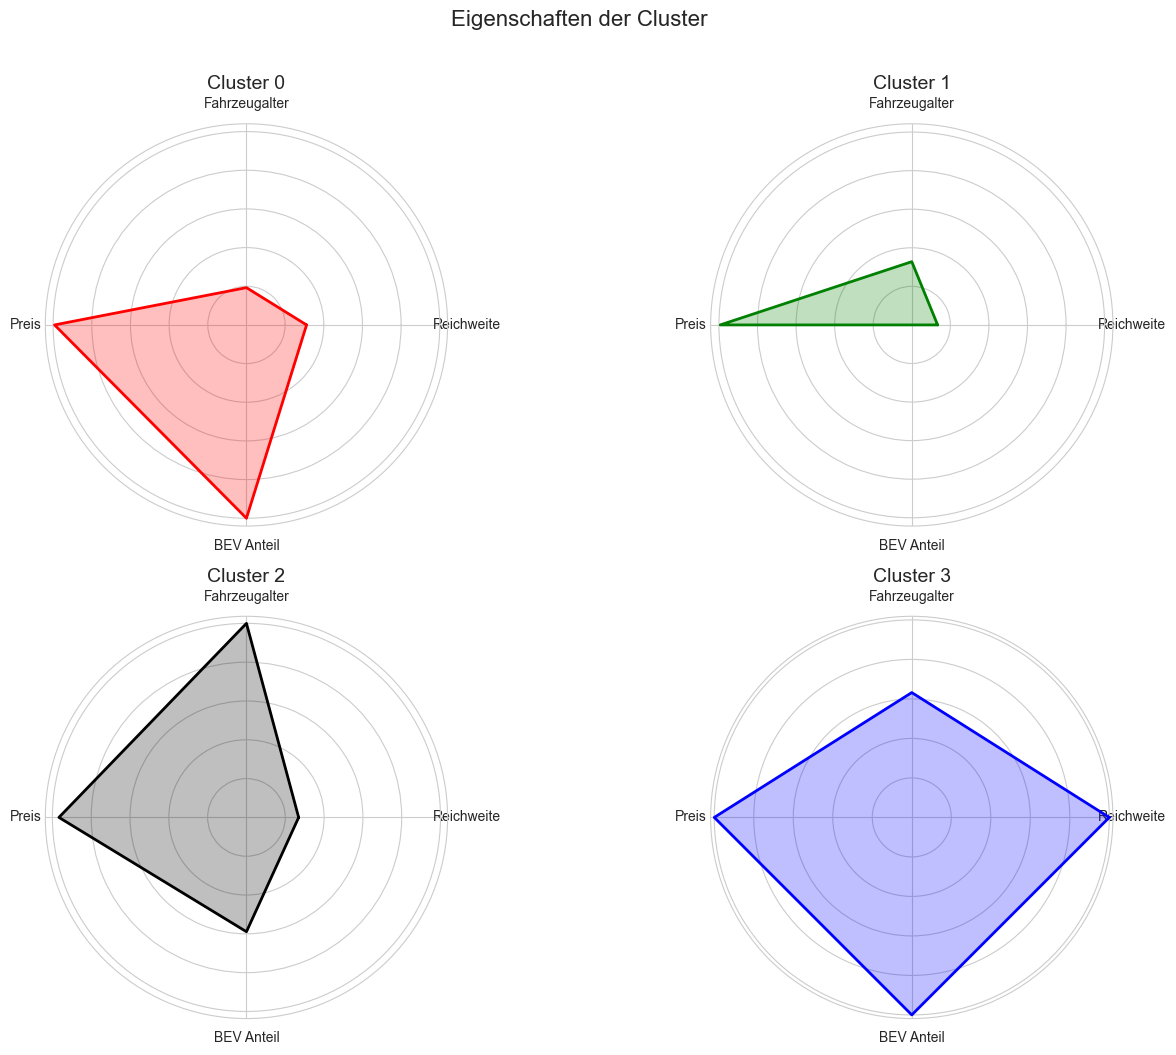

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

features_for_radar = ['Electric Range', 'Vehicle_Age', 'Base MSRP', 'EV_Type']
features_names = ['Reichweite', 'Fahrzeugalter', 'Preis', 'BEV Anteil']
n_features = len(features_for_radar)

normalized_centers = []
for i in range(n_clusters):
    cluster_center = centers[i, :-1]  
    normalized_centers.append(cluster_center / np.max(centers[:, :-1], axis=0))

angles = np.linspace(0, 2*np.pi, n_features, endpoint=False).tolist()
angles += angles[:1] 

fig, axs = plt.subplots(2, 2, figsize=(14, 10), subplot_kw=dict(polar=True))
axs = axs.flatten()

colors = ['red', 'green', 'black', 'blue']

for i in range(n_clusters):
    values = normalized_centers[i].tolist()
    values += values[:1]  
    
    ax = axs[i]
    ax.plot(angles, values, color=colors[i], linewidth=2)
    ax.fill(angles, values, color=colors[i], alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features_names)
    ax.set_title(f'Cluster {i}', size=14)
    
    ax.grid(True)
    ax.set_yticklabels([])
    
plt.tight_layout()
plt.suptitle('Eigenschaften der Cluster', size=16, y=1.05)
plt.show()